# 0. Set up
## 0.1 If if needed, clone Demeter with git

In [1]:
import matplotlib.pyplot as plt
!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 5702, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 5702 (delta 159), reused 188 (delta 111), pack-reused 5441 (from 1)
Receiving objects: 100% (5702/5702), 619.71 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (3727/3727), done.
Updating files: 100% (176/176), done.


In [ ]:
!git pull origin feature/002-rotation

From https://github.com/antonfrancois/Demeter_metamorphosis
 * branch            feature/002-rotation -> FETCH_HEAD
Already up to date.


In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git


and install the package

In [1]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/


print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=6d8ccd000dabb993ae208f6a37bcee228aee17163af9113b4ad08f96e3bd0052
  Stored in directory: /tmp/pip-ephem-wheel-cache-ogx3lz1g/wheels/c7/71/aa/4dfac81c8e26328effd94ced03987bdc69e149508d2e247f6c
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
['/content/Demeter_metamorphosis', 

In [2]:
!pip install pynrrd
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 After jupyter restart, run :

In [1]:


import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



/content/Demeter_metamorphosis
['/content/Demeter_metamorphosis/', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/content/Demeter_metamorphosis/src', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython']


# 1. code utile

## imports

In [1]:
import demeter.utils.torchbox as tb
from demeter.constants import *
import demeter.metamorphosis as mt
import demeter.utils.reproducing_kernels as rk
import demeter.utils.rigid_exploration as rg
from matplotlib.colors import ListedColormap
import sys
import os
cmap_segs = ListedColormap(
    [[0,0,0,0],
     'tab:blue',
     'tab:blue',
     'tab:orange'
     ])
DLT_KW_SEG= dict(alpha=.5,
                 cmap=cmap_segs,
                 interpolation='nearest'
                 )

# Add the directory containing brats_utils to the Python path
brats_utils_path = os.path.join(os.path.abspath('.'), 'examples/') # Assuming brats_utils is in a 'src' subdirectory
print(brats_utils_path)

if brats_utils_path not in sys.path:
    sys.path.insert(0, brats_utils_path)

import brats_utils as bu

%load_ext autoreload
%autoreload 2
import demeter.metamorphosis.rotate as mtrt
import demeter.utils.axes3dsliders_plt as a3s
from scipy.spatial.transform import Rotation as R

# from ipywidgets import ToggleButton, ToggleButtonStyle
from ipywidgets.widgets.widget_bool import ToggleButtonStyle


# term_width = os.get_terminal_size().columns
term_width = 30


def prepare_momenta(image_shape,
                    image : bool = True,
                    rotation : bool = True,
                    translation : bool = True,
                    rot_prior = None,
                    trans_prior= None,
                    device = "cuda:0",
                    requires_grad = True):
    dim = 2 if len(image_shape) == 4 else 3
    if rot_prior is None:
        rot_prior = torch.zeros((dim,))
    if trans_prior is None:
        trans_prior = [0] * dim
    momenta = {}
    kwargs = {
        "dtype":torch.float32,
        "device":device
    }
    if image:
        momenta["momentum_I"]= torch.zeros(S.shape,**kwargs)
    if rotation:
        if len(rot_prior.shape)==2:
            momenta["momentum_R"] = torch.tensor(rot_prior,**kwargs)
        elif len(rot_prior.shape)==1:
            r1, r2, r3 = rot_prior
            momenta["momentum_R"] = torch.tensor(
            [[0,-r1, -r2 ],
                     [r1, 0, -r3],
                     [r2, r3, 0]],
                    dtype=torch.float32, device='cuda:0')
        else:
            raise ValueError("Rotation prior must be 2 or 1 dimensional")
    if translation:
        momenta["momentum_T"]= torch.tensor(trans_prior,
                                            **kwargs)

    for keys in momenta.keys():
        momenta[keys].requires_grad=requires_grad

    return momenta

def random_affine_def():
    rdm_angle = torch.randn((3,))/4
    rdm_translation = torch.randn((3,))/15

    args_aff = torch.cat(
        [
            rdm_angle,
            rdm_translation,
            torch.ones_like(rdm_angle)
        ], dim = 0
    )
    print(args_aff)

    # args_aff = torch.tensor(
    #         [.6,-.3, 0, # angle
    #         .1,.02,0,   # translation
    #         1,1,1] # scaling
    # )
    aff_mat = tb.create_affine_mat_3d(args_aff)
    print(aff_mat)
    aff_grid = tb.affine_to_grid_3d(aff_mat, img_1.shape[2:])
    return aff_grid, aff_mat


def pixel_to_2square_landmark(landmarks, image_size):
    if len(image_size) > 3:
        image_size = image_size[2:]
    landmarks = landmarks.clone().float()
    for i in range(landmarks.shape[1]):
        landmarks[:,i] *= 2/ (image_size[i] )
    return landmarks - 1

def test_pixel_to_2square_landmark():
    landmarks = torch.tensor(
        [[0,0,0],[240,240,155],[240//2, 240//2, 155//2]]
    )
    img_shape = (1, 1, 240, 240, 155)
    expected_result = torch.tensor([[-1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000, -0.0065]])
    actual_result = pixel_to_2square_landmark(landmarks, img_shape)
    print('landmarks',landmarks)
    print("landmarks processed",pixel_to_2square_landmark(landmarks,img_shape))
    assert expected_result == actual_result

def apply_aff_to_landmarks(landmarks, grid):
    """
    Transport landmarks by a deformation grid.
    """
    new_land = torch.zeros_like(landmarks)
    for i, l in enumerate(landmarks):
        new_land[i]  = grid[:, int(l[2]), int(l[1]), int(l[0])]            # Bad orient

    return new_land

def inverse_affine(affine):
    """
    Compute the inverse of the affine transformation.
    """
    rot = affine[:3, :3]
    trans = affine[:3, 3][None]
    inv_rot = rot.T
    inv_trans = - trans.T

    new_aff = torch.cat([inv_rot, inv_trans], dim=1)
    return  torch.cat([new_aff, affine[-1][None]], dim=0)

def plot_metamorphosis_slices(mr):
    """
    Plots slices of the metamorphosis images at each time step and compares them
    to the target image.

    Args:
        mr: An object representing the metamorphosis process, expected to have
            an attribute mr.mp.image_stock (tensor of shape [T, 1, D, H, W])
            and mr.target (tensor of shape [1, D, H, W]).
    """

    # mr.to_device('cpu')
    image_stock = mr.mp.image_stock.cpu()  # Remove channel dim and move to numpy
    T, _, D, H, W = image_stock.shape

    # apply rotation to target
    rot_def =  mr.mp.get_rotator_translator()
    print("rot_def device:", rot_def.device)

    rotated_img_stock = tb.imgDeform(mr.mp.image_stock.cpu(),rot_def.cpu(),dx_convention='2square')

    # Choose a central slice for plotting
    slice_index = W // 2
    target_tensor = mr.target[..., slice_index].to("cpu") # Get the slice and add batch/channel dims


    fig, axes = plt.subplots(T, 2, figsize=(10, T * 5))

    for t in range(T):
        # Plot the metamorphosis image slice
        axes[t, 0].imshow(rotated_img_stock[t,0, :, :,slice_index], cmap='gray')
        axes[t, 0].set_title(f'Time Step {t}')
        axes[t, 0].axis('off')

        # Plot the comparison with the target image using tb.imgCmp
        # tb.imgCmp expects tensors, so convert numpy arrays back to tensors
        img = rotated_img_stock[t, ..., slice_index][None].to("cpu")

        comparison_img = target_tensor[0,0]
        # comparison_img = tb.imCmp(img, target_tensor, "compose")[0]
        print("comparison_img shape",comparison_img.shape)

        axes[t, 1].imshow(comparison_img, cmap='gray') # Use 'gray' or adjust cmap as needed
        axes[t, 1].set_title(f'Comparison with Target (Time Step {t})')
        axes[t, 1].axis('off')

    plt.tight_layout()
    plt.show()

def my_cmp(im1,im2):
    return tb.imCmp(torch.Tensor(im1)[None,None],torch.Tensor(im2)[None,None],
                    method="compose"
                    )[0]

def add_int_vs_target(subfig,mr,slice):
    target_long = tb.make_3d_flat(mr.target[0,0],slice)
    I1_long = tb.make_3d_flat(mr.mp.image[0,0],slice)

    ax = subfig.subplots()
    set_ticks_off(ax)
    ax.imshow(my_cmp(target_long,I1_long)) # ,cmap='PuOr'
    ax.set_title("Final integration")

def make_integration_fig(subfig,mr,slice,n_plots=4,
                         show_source_target= True,
                         ylabel=True,
                         cmp_mask=False):
    sst = show_source_target
    ax = subfig.subplots(n_plots+2*sst,1)
    set_ticks_off(ax)
    title = 'Mask evolution' if cmp_mask else 'Integration'
    ax[0 + 1*sst].set_title(title)
    for i in range(n_plots):
        coord = i*(mr.mp.n_step-1)//(n_plots-1)
        img_3D = mr.mp.image_stock[coord,0]
        long_img= tb.make_3d_flat(img_3D,slice)
        if cmp_mask:
            mask_flat = tb.make_3d_flat(mr.mp.rf.mask[coord,0],slice)
            # ax[i+1*sst].imshow(my_cmp(long_img,mask_flat),cmap='gray')
            ax[i+1*sst].imshow(long_img,cmap='gray',vmin=0,vmax=1)
            ax[i+1*sst].imshow(mask_flat,**DLT_KW_SEG)

        else:
            ax[i+1*sst].imshow(long_img,cmap='gray',vmin=0,vmax=1)
        if ylabel:
            ax[i+1*sst].set_ylabel(f"t = {(i*mr.mp.n_step//(n_plots-1))/mr.mp.n_step}")
    if sst:
        ax[0].imshow(tb.make_3d_flat(mr.source[0,0],slice),cmap='gray',vmin=0,vmax=1)
        ax[0].set_title('Source')
        ax[-1].imshow(tb.make_3d_flat(mr.target[0,0],slice),cmap='gray',vmin=0,vmax=1)
        ax[-1].set_title('Target')
    return ax

def make_deform_only_fig(subfig,mr,slice):
    deformator = mr.mp.get_deformator()
    S_deformed = tb.imgDeform(mr.source.cpu(),deformator,dx_convention='pixel')
    S_def_long = tb.make_3d_flat(S_deformed[0,0],slice)
    target_long = tb.make_3d_flat(mr.target[0,0],slice)

    ax = subfig.subplots(2,1)
    set_ticks_off(ax)
    ax[0].imshow(S_def_long,cmap='gray',vmin=0,vmax=1)
    ax[0].set_title('Deformation only')
    ax[1].imshow(my_cmp(target_long,S_def_long))# ,cmap='PuOr'
    ax[1].set_axis_off()

def make_summary_fig(mr,slice,save = False):
    # temporal_integrator = vff.FieldIntegrator(method='temporal',save=False,dx_convention='pixel')
    # deformation = mr.mp.get_deformation()
    cm = 1/2.54
    fig = plt.figure(figsize=(9*cm,13*cm),constrained_layout = True)

    subfigs = fig.subfigures(1, 2, wspace=0.07,width_ratios=[1,.7])
    make_integration_fig(subfigs[0],mr,slice, show_source_target=True)

    subfig_right = subfigs[1].subfigures(2,1,height_ratios=[1,2])
    make_deform_only_fig(subfig_right[0],mr,slice)
    add_int_vs_target(subfig_right[1],mr,slice)
    # plt.show()
    return fig

saves_overview.csv
/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/examples/examples/
🔍 Vérification de l'environnement Matplotlib interactif...
✅ ipympl est installé.
✅ `%matplotlib widget` activé avec succès.
✅ Backend interactif actif : widget
🎉 Environnement prêt pour les mises à jour dynamiques avec `.set_data()` et sliders interactifs !


/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/data_cost.py:418: SyntaxWarning: invalid escape sequence '\c'
  """


# Open raw images

In [2]:
brats_list = [
        # "BraTSReg_086",
        #"BraTSReg_090","BraTSReg_084",
        # "BraTSReg_046",
        # "BraTSReg_002",
    "BraTSReg_021",
    #     "BraTSReg_040",
    # "BraTSReg_118","BraTSReg_114","BraTSReg_132",

        # "BraTSReg_101","BraTSReg_073","BraTSReg_025","BraTSReg_022","BraTSReg_068","BraTSReg_120","BraTSReg_031","BraTSReg_088","BraTSReg_006","BraTSReg_003","BraTSReg_024","BraTSReg_035","BraTSReg_076","BraTSReg_012","BraTSReg_123",
    # 'BraTSReg_034',
    #     'BraTSReg_048',
    # 'BraTSReg_055', 'BraTSReg_082', 'BraTSReg_045', 'BraTSReg_089', 'BraTSReg_057',
        # 'BraTSReg_096', 'BraTSReg_083', 'BraTSReg_042', 'BraTSReg_061', 'BraTSReg_074', 'BraTSReg_097', 'BraTSReg_056', 'BraTSReg_033', 'BraTSReg_136', 'BraTSReg_119', 'BraTSReg_108', 'BraTSReg_054', 'BraTSReg_091', 'BraTSReg_100', 'BraTSReg_030', 'BraTSReg_126', 'BraTSReg_133', 'BraTSReg_138', 'BraTSReg_053', 'BraTSReg_110', 'BraTSReg_079',
    # 'BraTSReg_008', 'BraTSReg_131', 'BraTSReg_001', 'BraTSReg_023', 'BraTSReg_064', 'BraTSReg_067', 'BraTSReg_115', 'BraTSReg_029', 'BraTSReg_093', 'BraTSReg_129', 'BraTSReg_005',
    #  'BraTSReg_140',
        #'BraTSReg_036', 'BraTSReg_071'
    ]


device = 'cuda:0'
valid = False
brats_folder= '2022_valid' if valid else '2022_train'
modality = 'flair'
pb = bu.parse_brats(brats_list=brats_list,brats_folder=brats_folder,modality=modality)
save_folder = None
scale_img = .3

i = 0
name = brats_list[i]
img_1,img_2,seg_1,seg_2,landmarks = pb(i,to_torch=True,scale=scale_img,modality=modality)
img_1, img_2 = bu.normalize_mri_with_gliomas(img_1, img_2, seg_1, seg_2, verbose=True)
# img_1 = torch.nn.functional.pad(img_1,(0,0,10,20,0,0), "constant",.5)
print(landmarks[0].shape)
print(img_1.shape)
print(img_2.shape)
# land_2square =  pixel_to_2square_landmark(landmarks[0], img_1.shape)
# ic(landmarks,land_2square)
land_1, land_2 = landmarks
# land_1 =  land_0 +5
print("landmarks 0 \n",land_1)
print("landmarks 1 \n", land_2)
id_grid = tb.make_regular_grid( img_1.shape[2:])

# ias = a3s.Image3dAxes_slider(img_1)
# plt.show()


[img_1]
  Normalized img_1 to [0, 1771.811]

[img_2]
  Normalized img_2 to [0, 1233.871]

→ SSD before common normalization: 1326.3081

→ Common max: 1.015
→ img_1 range: [0.000, 0.996]
→ img_2 range: [0.000, 1.000]
→ SSD after common normalization: 1286.4906
torch.Size([6, 3])
torch.Size([1, 1, 72, 72, 46])
torch.Size([1, 1, 72, 72, 46])
landmarks 0 
 tensor([[16.8000, 26.4000, 21.0000],
        [20.4000, 43.8000, 36.0000],
        [23.7000, 45.3000, 36.0000],
        [21.9000, 36.3000, 17.1000],
        [15.6000, 27.0000, 35.7000],
        [13.8000, 31.8000, 32.1000]])
landmarks 1 
 tensor([[17.7000, 26.4000, 20.7000],
        [20.4000, 43.8000, 36.6000],
        [22.8000, 46.2000, 36.0000],
        [22.2000, 36.0000, 17.1000],
        [15.6000, 27.0000, 36.0000],
        [14.7000, 31.8000, 32.1000]])


# Classical Metamorphosis for tuning

True
momenta type <class 'torch.Tensor'>


/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Progress: [##--------]  20.00%  (Ssd : ,  8.9436).
Progress: [###-------]  30.00%  (Ssd : ,  8.9436).
Progress: [####------]  40.00%  (Ssd : ,  8.9436).
Progress: [#####-----]  50.00%  (Ssd : ,  8.9436).
Progress: [######----]  60.00%  (Ssd : ,  8.9436).
Progress: [#######---]  70.00%  (Ssd : ,  8.9436).
Progress: [########--]  80.00%  (Ssd : ,  8.9436).
Progress: [#########-]  90.00%  (Ssd : ,  8.9436).
Progress: [##########] 100.00% Done...
 (Ssd : ,  8.9436).

Computation of forward done in  0:00:02s and 0.374cents  s

Computation of metamorphosis done in  0:00:02s and 0.375cents  s


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 0.1 rho = 0.0'}>, <Axes: >],
       dtype=object))

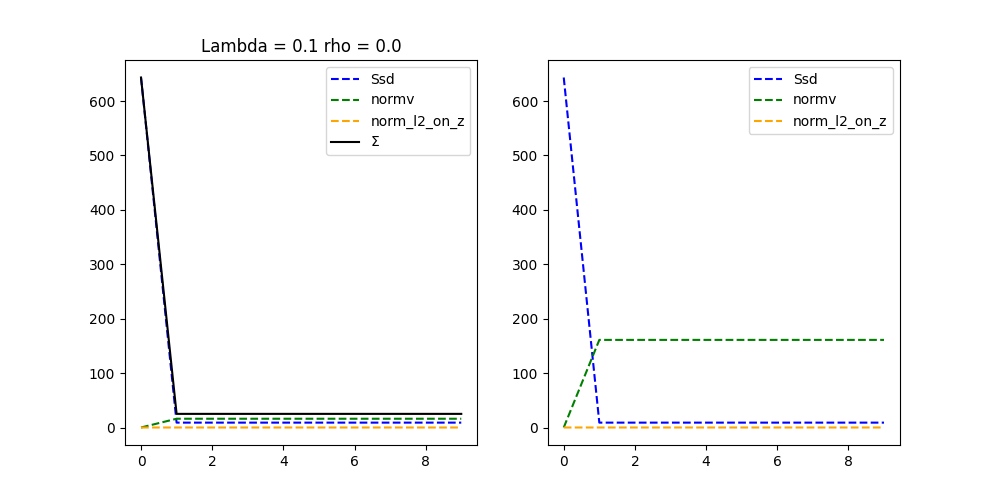

In [13]:
kernelOperator = rk.GaussianRKHS(sigma=(5,5,5),normalized=False)
# datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)
datacost = None

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=True,
    rotation=False,
    translation=False,
)

for v in momenta.values():
    print(v.requires_grad)

momentum_I = momenta["momentum_I"]

mr = mt.metamorphosis(
    img_1, img_2, momentum_ini=momentum_I,
    kernelOperator= kernelOperator,
    rho = 0,
    data_term=datacost ,
    integration_steps = 3,
    cost_cst=.1,
    n_iter=10,
    grad_coef=1,
    save_gpu_memory=True,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)

mr.plot_cost()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05620303750038147..1.0].


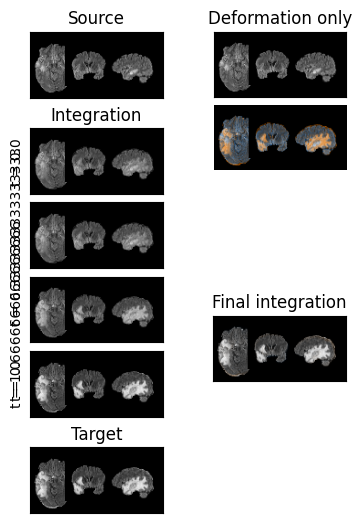

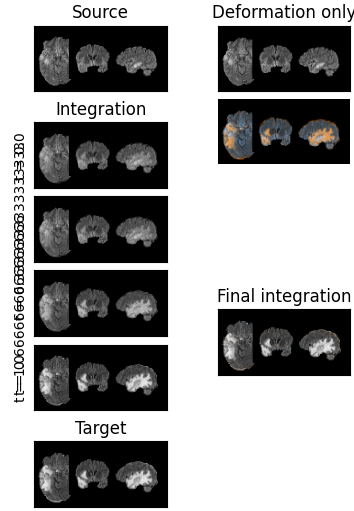

In [15]:
my_slice = (55,96,75)
my_slice = tuple([s*scale_img for s in my_slice])
make_summary_fig(mr,my_slice)

In [ ]:
name_tosave = f"{name}_metamorphosis_rho{mr.mp.rho}"
mr.save(name_tosave)

/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/abstract.py:1572: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(path)
ic| abstract.py:1572 in save()
    '/home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/'


Optimisation saved in /home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/3D_20250723_BraTSReg_021_metamorphosis_rho1_turtlefox_000.pk1 



('3D_20250723_BraTSReg_021_metamorphosis_rho1_turtlefox_000.pk1',
 '/home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/')

# RIGID


In [3]:
# torch.manual_seed(0)
# grid, affine = random_affine_def()

param = torch.tensor([
    0,0,torch.pi/4,
    0,0,0,
    1,1,1
])
affine = tb.create_affine_mat_3d(param)
grid = tb.affine_to_grid_3d(affine, img_1.shape[2:])
inv_aff = inverse_affine(affine)
inv_grid = tb.affine_to_grid_3d(inv_aff, img_1.shape[2:])

img_1_aff = tb.imgDeform(img_1, grid  )

inv_grid = tb.square2_to_pixel_convention(inv_grid,True)
land_1_aff = apply_aff_to_landmarks(land_1, inv_grid)


print("affine :", affine)
print("land_0_aff", land_1_aff)
# a3s.compare_images_with_landmarks(img_1, img_1_aff, land_1, land_1_aff, labels = ["origin", "displaced"])

print("Images ready to be registred")
print("^"*term_width)

source =  img_1_aff.contiguous()
target  = img_2.contiguous()

affine : tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7071, -0.7071,  0.0000],
        [-0.0000,  0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
land_0_aff tensor([[16.0000, 18.5294, 31.9645],
        [20.0000, 41.1569, 30.5503],
        [23.0000, 42.5711, 29.1360],
        [21.0000, 22.7721, 22.0650],
        [15.0000, 29.1360, 41.1569],
        [13.0000, 29.8431, 36.2071]])
Images ready to be registred
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Apply Metamorphosis  with rigid
## barycentre alignement

In [4]:
print("="*term_width)
print("Barycentre alignement\n")
shape_list = torch.tensor(source.size()[2:])/2
print(source.shape)
print(shape_list)

source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
land_1_b = land_1 - trans_s * shape_list
land_2_b = land_2 - trans_t * shape_list
print(land_1, land_1_b)
print(land_2, land_2_b)
# a3s.compare_images_with_landmarks(source, source_b,
#                                   land_1, land_1_b,
#                                   labels = ["source", "source_barycentred"])
# a3s.compare_images_with_landmarks(target, target_b,land_2, land_2_b,
#                                   labels = ["target", "target_barcentred"])
# a3s.compare_images_with_landmarks(source_b, target_b,
#                                   land_1_b, land_2_b,
#                                   labels = ["source_barycentred", 'target_barcentred'])

Barycentre alignement

torch.Size([1, 1, 72, 72, 46])
tensor([36., 36., 23.])
S compute barycentre : tensor([-0.0959,  0.0721, -0.0844])
T compute barycentre : tensor([-0.0788,  0.1303, -0.0549])
diff :  tensor([0.0170, 0.0582, 0.0295])
tensor([[16.8000, 26.4000, 21.0000],
        [20.4000, 43.8000, 36.0000],
        [23.7000, 45.3000, 36.0000],
        [21.9000, 36.3000, 17.1000],
        [15.6000, 27.0000, 35.7000],
        [13.8000, 31.8000, 32.1000]]) tensor([[20.2513, 23.8038, 22.9406],
        [23.8513, 41.2038, 37.9406],
        [27.1513, 42.7038, 37.9406],
        [25.3513, 33.7038, 19.0406],
        [19.0513, 24.4038, 37.6406],
        [17.2513, 29.2038, 34.0406]])
tensor([[17.7000, 26.4000, 20.7000],
        [20.4000, 43.8000, 36.6000],
        [22.8000, 46.2000, 36.0000],
        [22.2000, 36.0000, 17.1000],
        [15.6000, 27.0000, 36.0000],
        [14.7000, 31.8000, 32.1000]]) tensor([[20.5377, 21.7082, 21.9624],
        [23.2377, 39.1082, 37.8624],
        [25.6377, 41

## Prepare Metamorphosis optimizer

In [5]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=1)

mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)

dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])


## Rigid Explorator

In [6]:

top_params = rg.initial_exploration(mr,r_step=5, max_output = 5, verbose=True)
print(top_params)

# top_params =  [
#     (torch.tensor(22700.7285), torch.tensor([-3.1416, -0.6283,  1.8850])),
#     (torch.tensor(22830.1152), torch.tensor([ 0.6283, -3.1416,  1.8850])),
# ]

Init search : 1 / 125
dict_keys(['momentum_R'])
	 (tensor(1246.1863), tensor([-3.1416, -3.1416, -3.1416]))
Init search : 2 / 125
dict_keys(['momentum_R'])


/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/rotate.py:282: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  momT_translated = momentum_T @ translation.T


	 (tensor(1259.4563), tensor([-3.1416, -3.1416, -1.8850]))
Init search : 3 / 125
dict_keys(['momentum_R'])
	 (tensor(1281.5399), tensor([-3.1416, -3.1416, -0.6283]))
Init search : 4 / 125
dict_keys(['momentum_R'])
	 (tensor(1334.2729), tensor([-3.1416, -3.1416,  0.6283]))
Init search : 5 / 125
dict_keys(['momentum_R'])
	 (tensor(1403.7668), tensor([-3.1416, -3.1416,  1.8850]))
Init search : 6 / 125
dict_keys(['momentum_R'])
	 (tensor(1271.2889), tensor([-3.1416, -1.8850, -3.1416]))
Init search : 7 / 125
dict_keys(['momentum_R'])
	 (tensor(1309.3208), tensor([-3.1416, -1.8850, -1.8850]))
Init search : 8 / 125
dict_keys(['momentum_R'])
	 (tensor(1311.5001), tensor([-3.1416, -1.8850, -0.6283]))
Init search : 9 / 125
dict_keys(['momentum_R'])
	 (tensor(1353.5059), tensor([-3.1416, -1.8850,  0.6283]))
Init search : 10 / 125
dict_keys(['momentum_R'])
	 (tensor(1387.8911), tensor([-3.1416, -1.8850,  1.8850]))
Init search : 11 / 125
dict_keys(['momentum_R'])
	 (tensor(1343.0857), tensor([-3.14

## Optimize Rigid on best values


In [7]:
# torch.autograd.set_detect_anomaly(True)
best_loss, best_momentum, best_translation, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)

# rot_def =   tb.grid_from_rotation(mr.mp.id_grid, best_rot.T)
# rot_def -= best_translation
# img_rot = tb.imgDeform(mr.mp.image, rot_def.to('cpu'),
#                        dx_convention='2square', clamp=True)
#
# a3s.compare_images_with_landmarks(img_rot, source_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "source_b"],)
#
# a3s.compare_images_with_landmarks(img_rot, target_b, land_1_b, land_2_b,
#                                   labels= ["img_rot", "target_b"],)

# best_momentum = torch. tensor([[ 0.0000, -0.4125, -0.1989],
#         [ 0.4125,  0.0000,  0.5446],
#         [ 0.1989, -0.5446,  0.0000]])
# best_translation = torch. tensor([ 0.0037,  0.0205, -0.0379])
# best_rotation = tensor([[ 0.0655,  0.8918,  0.4477],
#         [-0.9973,  0.0430,  0.0602],
#         [ 0.0344, -0.4504,  0.8921]])

>>>>>>>>>>
0/5 Optimize wit params [-0.6283185482025146, 0.6283185482025146, 1.884955644607544]
momenta type <class 'dict'>
Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,514.0859).
Progress: [###-------]  30.00%  (Rotation_Ssd_Cost : ,414.6040).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,414.6038).
Progress: [#####-----]  50.00%  (Rotation_Ssd_Cost : ,414.6038).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,414.6038).
Progress: [#######---]  70.00%  (Rotation_Ssd_Cost : ,414.6038).
Progress: [########--]  80.00%  (Rotation_Ssd_Cost : ,414.6038).
Progress: [#########-]  90.00%  (Rotation_Ssd_Cost : ,414.6038).
Progress: [##########] 100.00% Done...
 (Rotation_Ssd_Cost : ,414.6038).

Computation of forward done in  0:00:02s and 0.850cents  s
best = True
tensor([-0.0040, -0.0002,  0.0428])
tensor([[ 0.9994, -0.0241,  0.0264],
        [ 0.0357,  0.7010, -0.7122],
        [-0.0013,  0.7127,  0.7015]])
<<<<<<<<<<
>>>>>>>>>>
1/5 Optimize wit params [0.62831854820251

tensor([[ 0.0000, -0.0368,  0.0170],
        [ 0.0368,  0.0000, -0.8776],
        [-0.0170,  0.8776,  0.0000]], requires_grad=True)
tensor([-0.0040, -0.0002,  0.0428], requires_grad=True)
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
tensor([[ 0.9994, -0.0241,  0.0264],
        [ 0.0357,  0.7010, -0.7122],
        [-0.0013,  0.7127,  0.7014]], grad_fn=<MmBackward0>)


Text(0.5, 1.0, 'img vs source')

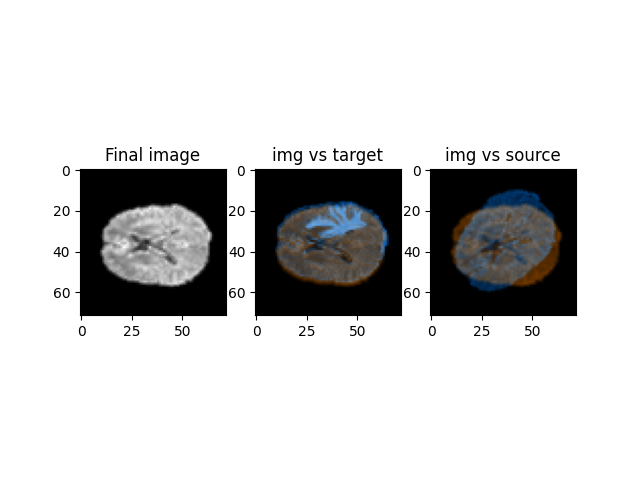

In [8]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=False,
    rotation=True,
    translation=True,
    rot_prior=best_momentum.detach().clone(),trans_prior=best_translation.detach().clone(),
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(img_1.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source, target, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source.cpu(), momenta, save=True)

print(mr.mp.rot_mat)

# rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
# rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
# rot_def += mr.mp.translation
rot_def = mr.mp.get_rotator_translator()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')
img = rotated_source[0,0,..., mr.source.shape[-1]//2].detach().cpu()
img_target = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.target[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.source[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
fig,ax = plt.subplots(1,3)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")

## Metamorphosis along rigid

Text(0.5, 1.0, 'target')

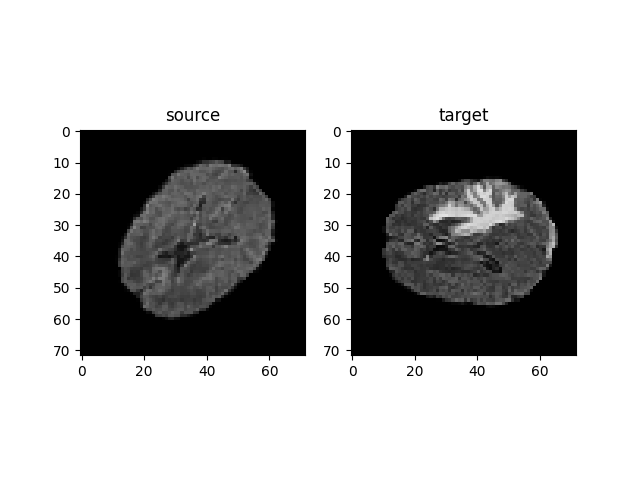

In [9]:
fig, ax = plt.subplots(1,2)
T, _, D, H, W = source.shape

max_st = max(source.max(), target.max())
min_st = min(source.min(), target.min())
# Choose a central slice for plotting
slice_index = W // 2
ax[0].imshow(source[0,0,..., slice_index], cmap='gray', clim=(min_st,max_st))
ax[0].set_title(f'source')

ax[1].imshow(target[0,0,..., slice_index], cmap='gray', clim=(min_st,max_st))
ax[1].set_title(f'target')

In [ ]:
# prompt: empty GPU memory
del mr
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

46016

(0.013888888888888888, 0.013888888888888888, 0.021739130434782608)
VolNormalizedGaussianRKHS,3D 
	filter :fft_filter, 
	sigma_pixel :tensor([3.6000, 3.6000, 2.3000])
	sigma_continous :tensor([0.0500, 0.0500, 0.0500])
	kernel_size :(1, 21, 21, 13)
True
True
True
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
momenta type <class 'dict'>
Progress: [#---------]  13.33%  (Rotation_Ssd_Cost : ,424.8085).
Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [###-------]  26.67%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [###-------]  33.33%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [#####-----]  46.67%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [#####-----]  53.33%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,424.8084).
Progress: [#######---]  66.67%  (Rotation_Ssd

(tensor([[16.0000, 26.0000, 21.0000],
         [20.0000, 43.0000, 36.0000],
         [23.0000, 45.0000, 36.0000],
         [21.0000, 36.0000, 17.0000],
         [15.0000, 27.0000, 35.0000],
         [13.0000, 31.0000, 32.0000]]),
 tensor(0.6167),
 tensor(0.3000))

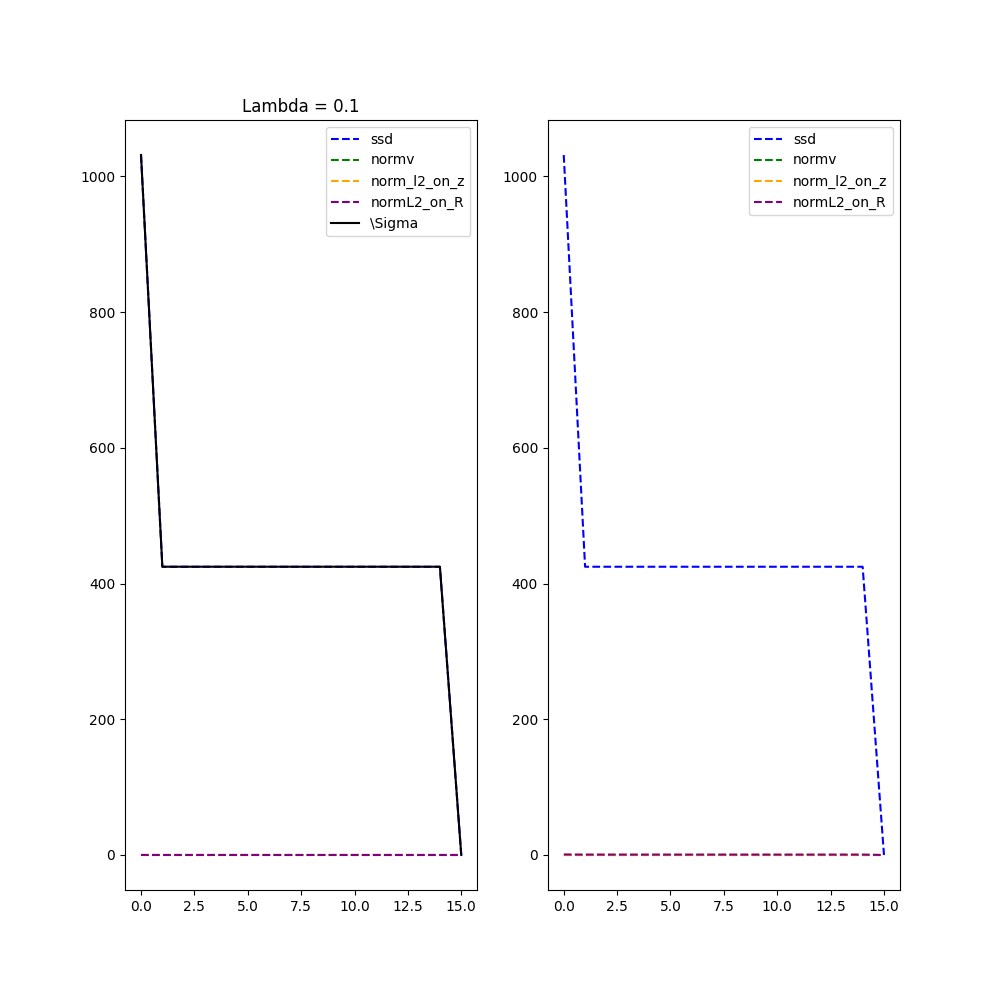

In [16]:
# kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
sigma = (.05,.05, .05)
dx = tuple( [1/s for s in source.shape[2:]] )
print(dx)
kernelOperator = rk.VolNormalizedGaussianRKHS(sigma=sigma,
                                              sigma_convention="continuous",
                                              dx = dx, 
                                              )
print(kernelOperator)
datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=1)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    img_1.shape,
    image=True,
    rotation=True,
    translation=True,
    rot_prior=best_momentum.detach().clone(),trans_prior=best_translation.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)

mr = mt.rigid_along_metamorphosis(
    source, target, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 0,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=1e-5,
    n_iter=15,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)

# mr = mt.metamorphosis(
#     img_1, img_2, momentum_ini=momenta,
#     kernelOperator= kernelOperator,
#     rho = 1,
#     data_term=datacost ,
#     integration_steps = 10,
#     cost_cst=.1,
#     n_iter=10,
#     grad_coef=1
# )

mr.plot_cost()
mr.compute_landmark_dist(land_1,  land_2)

# a3s.compare_images_with_landmarks(mr.mp.image, img_1,
#                                   labels= ["Final", "source"],)
# a3s.compare_images_with_landmarks(mr.mp.image, img_2,
#                                   labels= ["Final", "target_b"],)

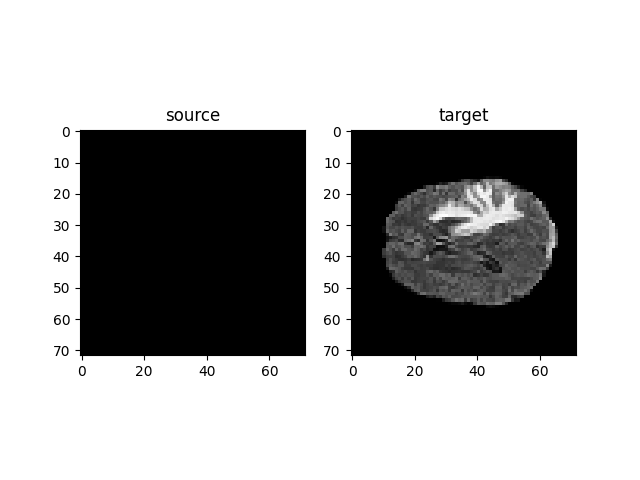

In [17]:
fig, ax = plt.subplots(1,2)
T, _, D, H, W = source.shape

# Choose a central slice for plotting
slice_index = W // 2
ax[0].imshow(mr.mp.residuals[0,0,..., slice_index].cpu(), cmap='gray')
ax[0].set_title(f'source')

ax[1].imshow(target[0,0,..., slice_index], cmap='gray')
ax[1].set_title(f'target')
plt.show()

rot_def device: cpu
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])
comparison_img shape torch.Size([72, 72])


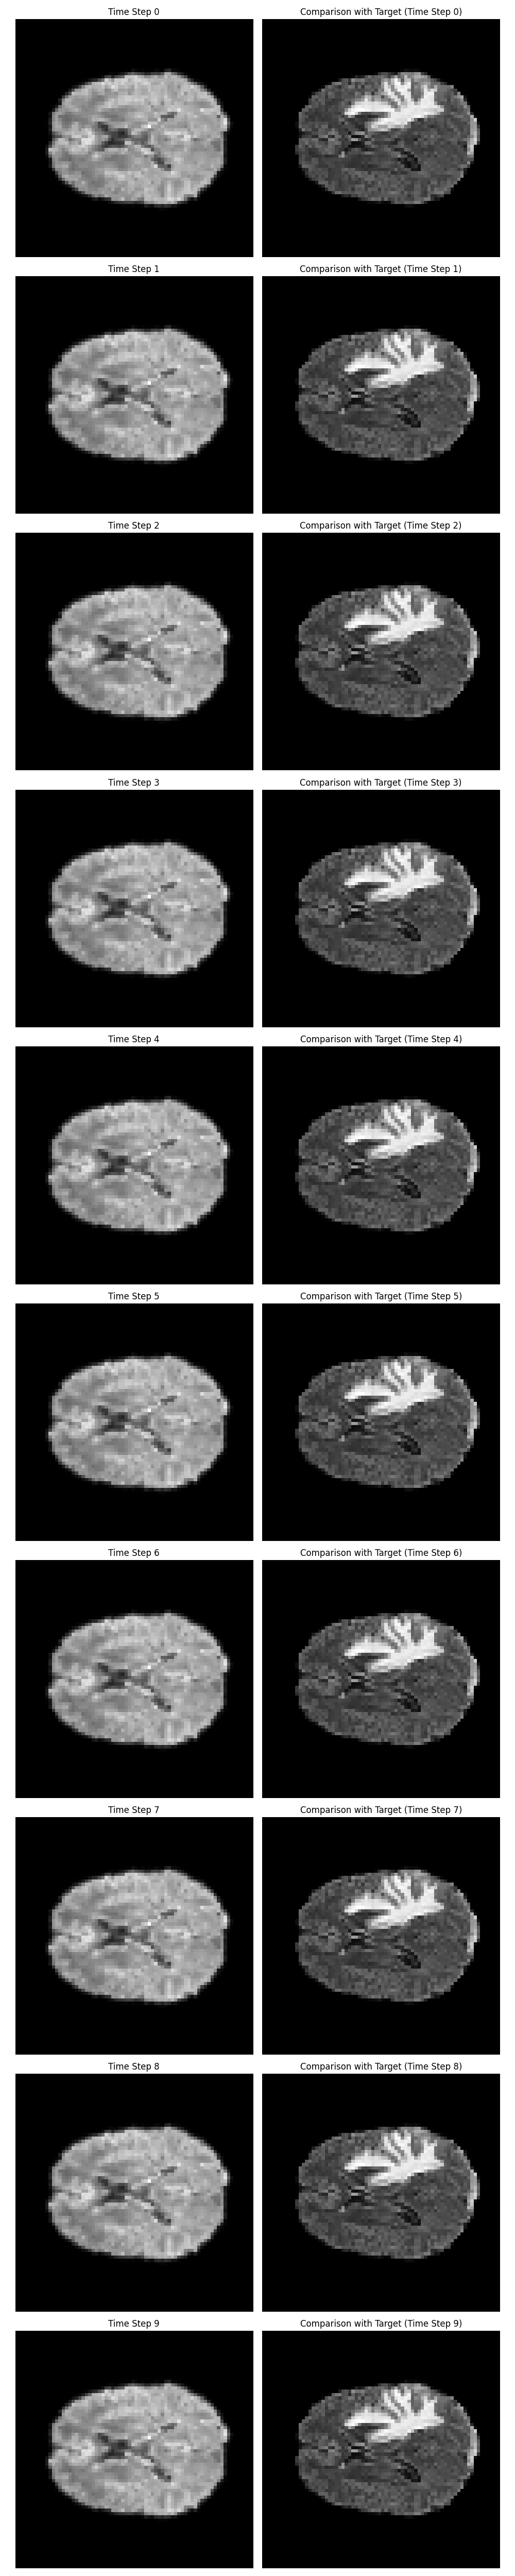

In [17]:
mr.to_device("cpu")
# Assuming 'mr' is the metamorphosis object created in the preceding code
plot_metamorphosis_slices(mr)


In [30]:
mr.save(f"{name}_rigid_metamorphosis_colab",save_path="/content/drive/MyDrive/demeter_data/demeter_optim/")

ic| abstract.py:1572 in save()
    path: '/content/drive/MyDrive/demeter_data/demeter_optim/'



BUG WARNING : An other data term than Ssd was detectedFor now our method can't save it, it is ok to visualisethe optimisation, but be careful loading the optimisation.

Optimisation saved in /content/drive/MyDrive/demeter_data/demeter_optim/3D_20250725_BraTSReg_021_rigid_metamorphosis_colab_root_000.pk1 



('3D_20250725_BraTSReg_021_rigid_metamorphosis_colab_root_000.pk1',
 '/content/drive/MyDrive/demeter_data/demeter_optim/')